In [ ]:
import osmnx as ox
import geopy
import folium
from geopy.geocoders import Nominatim
from geopy.distance import geodesic as geopy_distance
from geopy.extra.rate_limiter import RateLimiter
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import random
# Define a function to generate random coordinates within a given radius of a central point
def generate_random_coordinates(center_lat, center_lon, radius):
    # Generate random distance and angle
    random_distance = random.random() * radius
    random_angle = random.random() * 360
    # Calculate random point coordinates using geopy.distance
    return geopy_distance(kilometers=random_distance).destination((center_lat, center_lon), bearing=random_angle)


# Initialize geolocator with a user-agent
geolocator = Nominatim(user_agent="routing-system-big-data")

# List of areas to geocode
areas = ["Titan - Balta Albă", "Dristor Sector 3", "Dudesti Sector 3", "Pantelimon Sector 2"]
radius = 2  # Radius in kilometers within which to generate house locations
num_locations_per_area = 4  # Number of locations to generate per area

# Get central coordinates of the areas
central_coordinates = {area: geolocator.geocode(area) for area in areas}
# Generate house locations
house_locations = []
for area, location in central_coordinates.items():
    if location:
        for _ in range(num_locations_per_area):
            random_coords = generate_random_coordinates(location.latitude, location.longitude, radius)
            house_locations.append((random_coords[0], random_coords[1]))

# house_locations now contains the generated coordinates for the house locations
house_locations


In [ ]:
# Constants for the routing problem
CENTER_LOCATION = (44.413162, 26.163739)

HQ_COURIER = (44.387820, 26.168503)  # Replace with actual depot coordinates
DIST = 7000  # Adjust as needed
NUM_VEHICLES = 3  # Adjust as needed

# Get the road network graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
print(G)
*_, = ox.plot_graph(G)

In [ ]:
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
print(G)
*_, = ox.plot_graph(G)

In [ ]:
# Add depot to the list of locations
courier_destinations = [HQ_COURIER] + house_locations

# Find the nearest node to each location
destination_nodes = [ox.nearest_nodes(G, courier_destinations[i][1], courier_destinations[i][0]) for i in range(len(courier_destinations))]
# Function to calculate distance matrix using networkx
def calculate_distance_matrix(node_destinations, G):
    distance_matrix = []
    for node1 in node_destinations:
        row = []
        for node2 in node_destinations:
            length = round(nx.shortest_path_length(G, node1, node2, weight='length'))
            row.append(length)
        distance_matrix.append(row)
    return distance_matrix


distance_matrix = calculate_distance_matrix(destination_nodes, G)


In [ ]:
distance_matrix

In [ ]:
# Create and configure the Google OR-Tools routing model
def create_model(distance_matrix, num_vehicles):
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):

        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]


    transit_callback_index = routing.RegisterTransitCallback(distance_callback) 

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(transit_callback_index,
                          0,
                          30000, # max distance per vehicle
                          True,
                          dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    return routing, manager

In [ ]:
# Solve the OR-Tools routing problem

def solve_routing_problem(routing, manager):
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        return output_solution(solution, routing, manager)
    else:
        print("No solution found!")
        return []

def output_solution(solution, routing, manager):
    print("Routes:")
    total_distance = 0
    path_nodes = []
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        path_nodes.append([])
        index = routing.Start(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            path_nodes[vehicle_id].append(destination_nodes[manager.IndexToNode(index)])
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output = 'Distance travelled by vehicle {}: {}m\n'.format(vehicle_id, route_distance)
        path_nodes[vehicle_id].append(destination_nodes[0])
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))
    return path_nodes


# Now use these functions with your data
routing, manager = create_model(distance_matrix, NUM_VEHICLES)
path_nodes = solve_routing_problem(routing, manager)

In [ ]:
# Implement k-means algorithm for vehicle allocation
def k_means(distance_matrix, k):
    
    # Centroids is initialized with k random destinations
    centroids = random.sample([i for i in range(1, len(distance_matrix))], k)

    # Assignment of vehicle for each destination
    assignments = np.zeros(len(distance_matrix), dtype=int)
    
    # Assign each destination to the closest centroid
    for i in range(len(distance_matrix)):
        # Get the distance from the current destination to each centroid
        distances = [distance_matrix[i][centroid] for centroid in centroids]
        # Assign the index of the centroid with the minimum distance
        assignments[i] = np.argmin(distances)
    
    # Update the centroids based on the new assignments
    for i in range(k):
        # Get the destinations in the cluster as a list of indices
        cluster_vehicles = [j for j in range(len(distance_matrix)) if assignments[j] == i and j != 0]  # Exclude the depot
        # print(cluster_vehicles)
        # Distances from all destinations of cluster to all other destinations
        centroid_distances = [sum(distance_matrix[j][l] for l in cluster_vehicles) for j in range(len(distance_matrix)) if j != 0]  # Exclude the depot
        # Assign the new centroid as the destination with the minimum distance sum to all other destinations in the cluster
        # np.argmin returns the index of the minimum value in the array
        # Add 1 to the result because we're excluding the depot (index 0)
        centroids[i] = np.argmin(centroid_distances) + 1
        

    # Repeat steps 2 and 3 until convergence
    while True:
        previous_assignments = assignments.copy()
        assignments = np.zeros(len(distance_matrix), dtype=int)
        for i in range(len(distance_matrix)):
            # ...
            distances = [distance_matrix[i][centroid] for centroid in centroids]
            # ...
            assignments[i] = np.argmin(distances)

        if np.array_equal(assignments, previous_assignments):
            break

    return assignments

assignments = k_means(distance_matrix, NUM_VEHICLES)
assignments

In [ ]:
# Plot the results by both methods: k-means clustering and OR-Tools routing 
color_names = [
    'red', 'orange', 'yellow', 'green', 'blue',
    'indigo', 'violet', 'purple', 'pink', 'brown',
    'maroon', 'cyan', 'teal', 'lime', 'olive',
    'navy', 'gray', 'black', 'white', 'silver'
]

colors = []

In [ ]:

def findBestWayNodes(G, destination_nodes):
  # Create a directed graph for path finding
  directed_G = G.to_directed()
  # Start from HQ_COURIER
  current_location = destination_nodes[0]
  # Create a list to store the nodes in the path
  path_nodes = []
  # Add HQ_COURIER to the path
  path_nodes.append(current_location)
  
  for target_node in destination_nodes:
      # Find the shortest path to the target node from the current location
      shortest_path = nx.shortest_path(directed_G, source=current_location, target=target_node, weight='length')
      # Add the nodes in the shortest path to the overall path_nodes list
      path_nodes.extend(shortest_path[1:])  # Exclude the starting node as it's already added
      # Update the current location to the target node
      current_location = target_node

  # Find the shortest path back to HQ_COURIER
  shortest_path_back = nx.shortest_path(directed_G, source=current_location, target=path_nodes[0], weight='length')

  path_nodes.extend(shortest_path_back[1:])
  return path_nodes

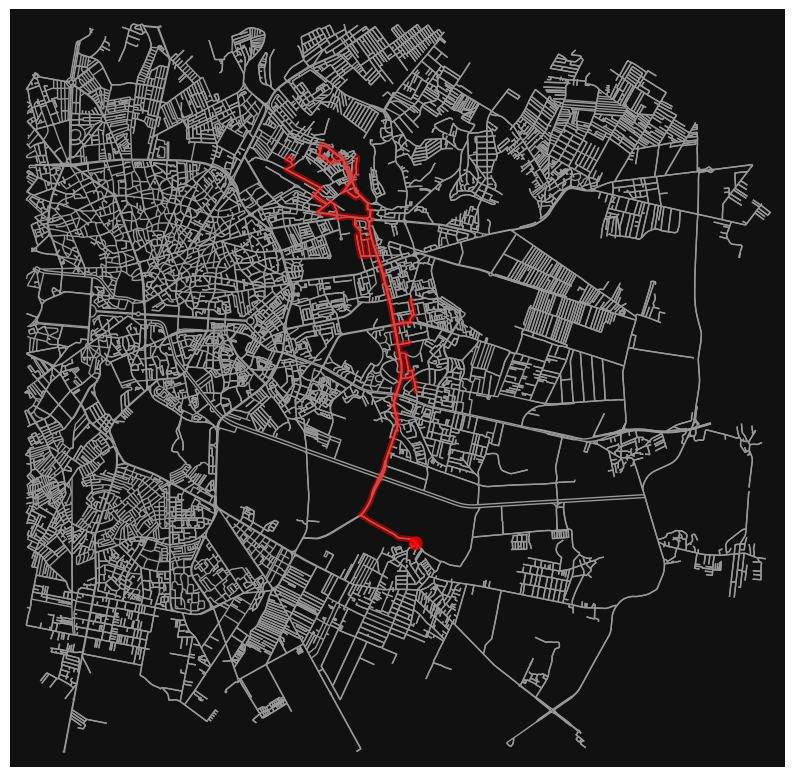

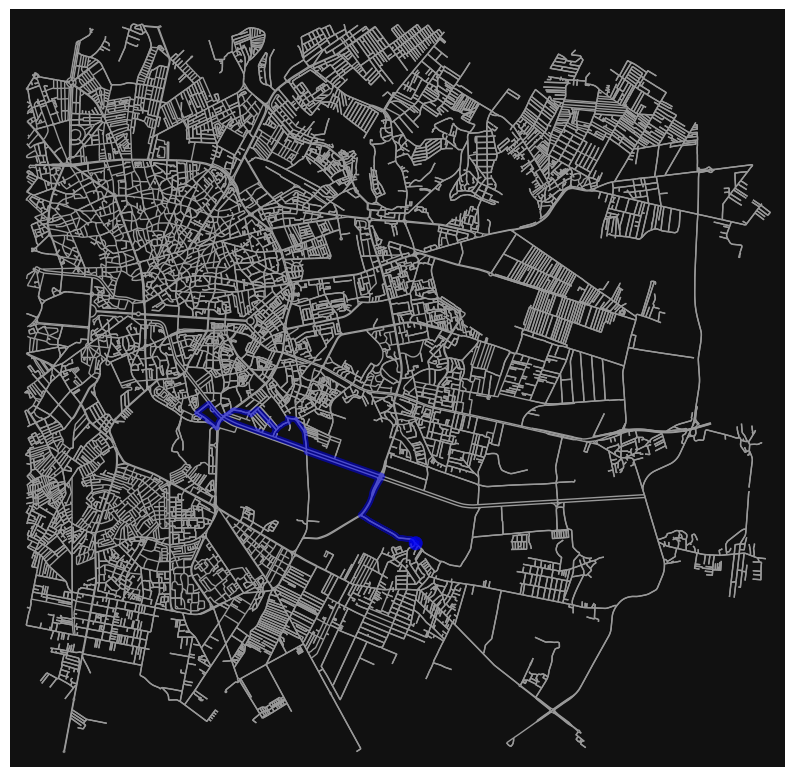

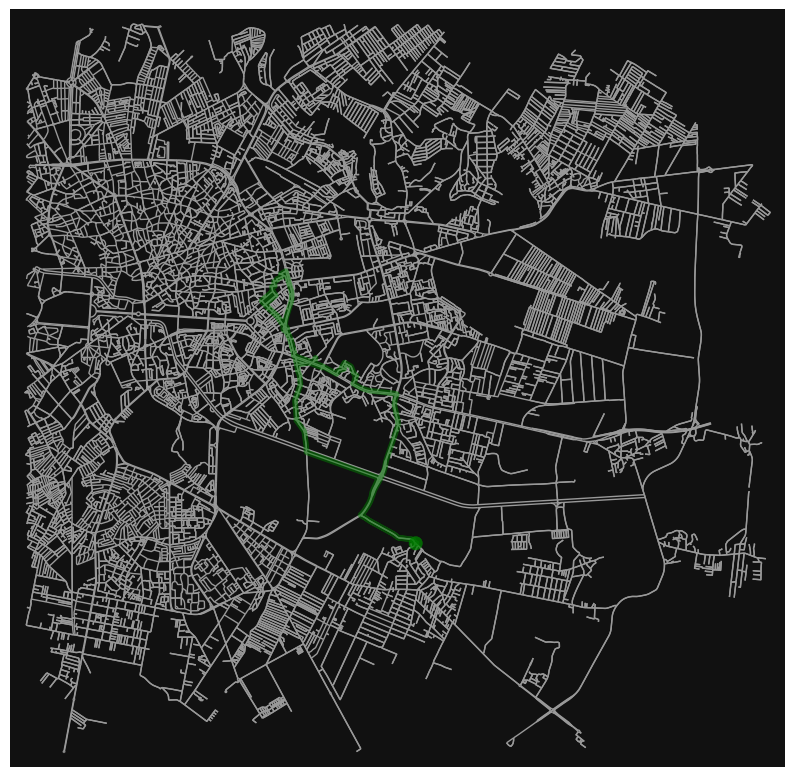

In [55]:
# K-means clustering plot

paths_kmeans = []
assigned_nodes = {}
for i in range(0, NUM_VEHICLES):
    depot = destination_nodes[0]
    assigned_nodes[i] = [destination_nodes[j] for j in range(len(distance_matrix)) if assignments[j] == i and j != 0] # Exclude the depot
    paths_kmeans.append(findBestWayNodes(G, [depot] + assigned_nodes[i]))
    colors.append(color_names[i])
for i in range(0, NUM_VEHICLES):
  fig, ax = ox.plot_graph_route(G, paths_kmeans[i], route_color=colors[i], node_size=0, figsize=(10, 10))
  # Add points for each edge in paths_kmeans[i]
  path_points = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in paths_kmeans[i]]
  plt.show()


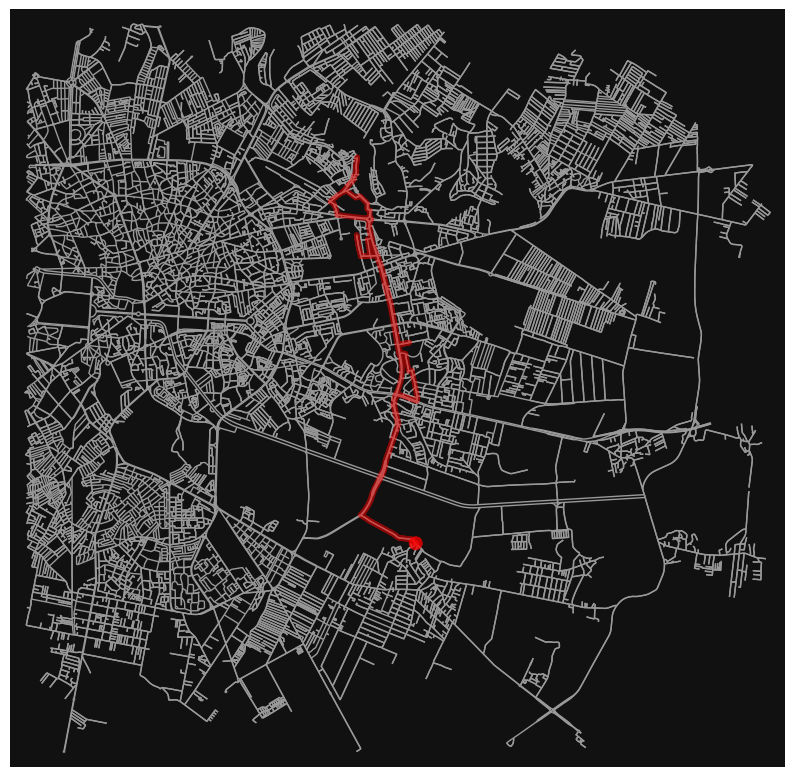

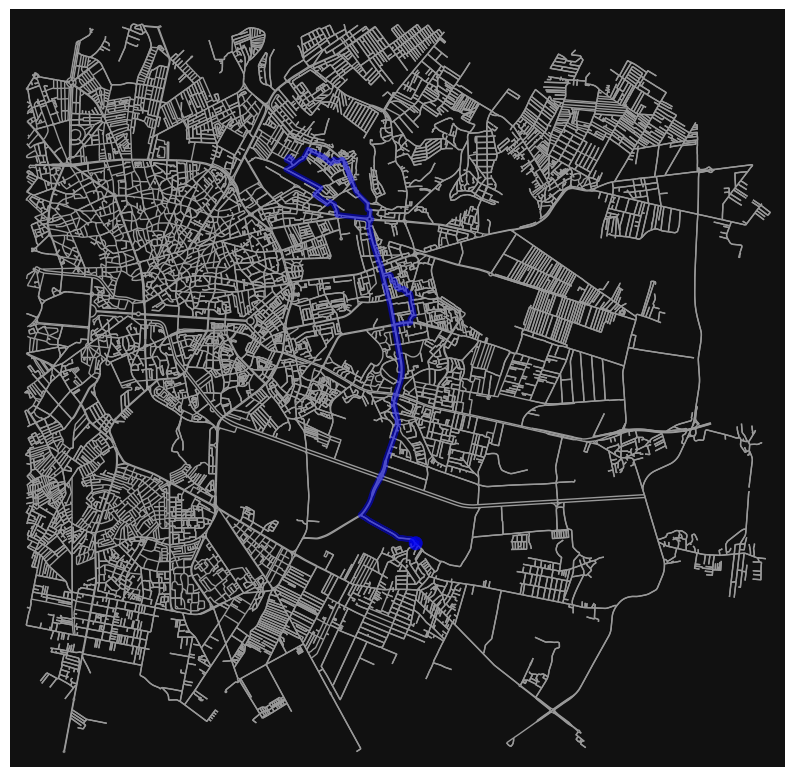

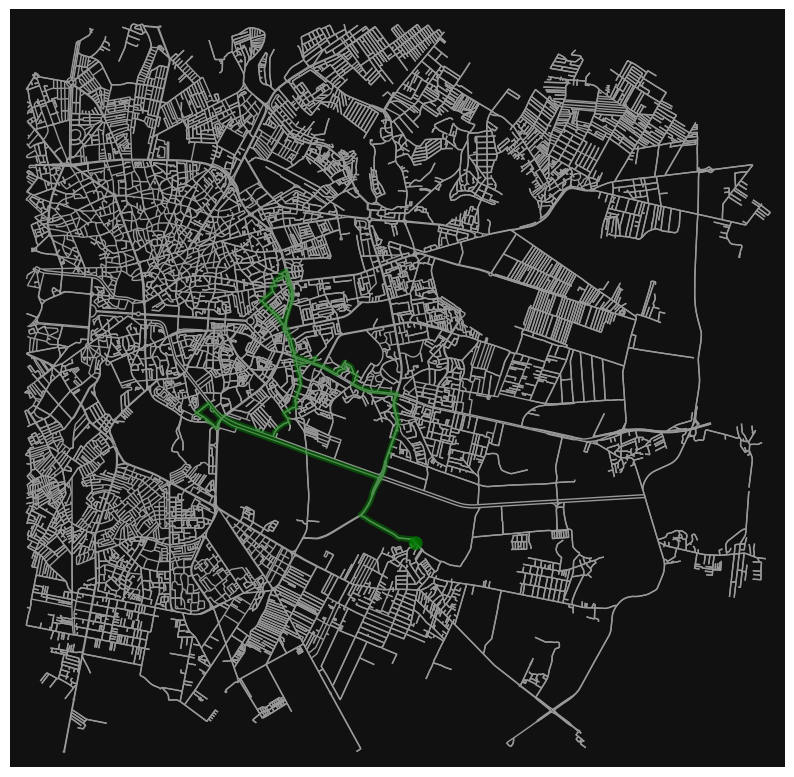

In [52]:
# OR-Tools routing plot

paths_ortools = []
for i in range(0, NUM_VEHICLES):
    depot = destination_nodes[0]
    paths_ortools.append(findBestWayNodes(G, path_nodes[i]))
    colors.append(color_names[i])
for i in range(0, NUM_VEHICLES):
  fig, ax = ox.plot_graph_route(G, paths_ortools[i], route_color=colors[i], node_size=0, figsize=(10, 10))
  # Add points for each edge in paths_ortools[i]
  path_points = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in paths_ortools[i]]

  # Display the legend
  ax.legend()
  plt.show()

In [59]:
# Create a folium map centered around the HQ_COURIER
map_center = HQ_COURIER
mymap = folium.Map(location=map_center, zoom_start=13)

# Define colors for each courier
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue']

# Plot the graph on the map
folium.Marker(location=HQ_COURIER[::-1], popup='HQ_COURIER', icon=folium.Icon(color='green')).add_to(mymap)

# Plot the routes and points for each courier
for i in range(NUM_VEHICLES):
    # Create a FeatureGroup for this courier's route and add it to the map
    courier_route = folium.FeatureGroup(name=f'Courier {i + 1} Route')
    mymap.add_child(courier_route)

    # K-means method
    route_coords_kmeans = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in paths_kmeans[i]]
    folium.PolyLine(locations=route_coords_kmeans, color=colors[i], weight=5, opacity=0.7, dash_array ='11').add_to(courier_route)
    for node in assigned_nodes[i]:
        folium.Marker(
            location=(G.nodes[node]['y'], G.nodes[node]['x']),
            popup=f'Courier {i + 1} Point',
            icon=folium.Icon(color=colors[i], icon='circle', prefix='fa')
        ).add_to(courier_route)
        

    # OR-Tools method
    # route_coords_ortools = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in paths_ortools[i]]
    # folium.PolyLine(locations=route_coords_ortools, color=colors[i], weight=5, opacity=0.7, dash_array='5').add_to(courier_route)
    # for node in path_nodes[i]:
        # folium.Marker(
            # location=(G.nodes[node]['y'], G.nodes[node]['x']),
            # popup=f'Courier {i + 1} Point',
            # icon=folium.Icon(color=colors[i], icon='circle', prefix='fa')
        # ).add_to(courier_route)
    
# Add a LayerControl to the map to allow toggling of each courier's route
folium.LayerControl().add_to(mymap)

# Save the map
mymap.save('couriers_map.html')